Check if Data is ready for Training

### Classes in MVTEC_AD dataset

In [2]:
from pathlib import Path

root = Path("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/raw/MVTEC_AD/mvtec_anomaly_detection")
classes = set()
for category in root.iterdir():
    if not category.is_dir():
        continue
    test_dir = category / "test"
    if test_dir.exists():
        for defect_type in test_dir.iterdir():
            if defect_type.is_dir() and defect_type.name != "good":
                classes.add(defect_type.name)

print(f"Total defect classes: {len(classes)}")
print(sorted(classes))


Total defect classes: 48
['bent', 'bent_lead', 'bent_wire', 'broken', 'broken_large', 'broken_small', 'broken_teeth', 'cable_swap', 'color', 'combined', 'contamination', 'crack', 'cut', 'cut_inner_insulation', 'cut_lead', 'cut_outer_insulation', 'damaged_case', 'defective', 'fabric_border', 'fabric_interior', 'faulty_imprint', 'flip', 'fold', 'glue', 'glue_strip', 'gray_stroke', 'hole', 'liquid', 'manipulated_front', 'metal_contamination', 'misplaced', 'missing_cable', 'missing_wire', 'oil', 'pill_type', 'poke', 'poke_insulation', 'print', 'rough', 'scratch', 'scratch_head', 'scratch_neck', 'split_teeth', 'squeeze', 'squeezed_teeth', 'thread', 'thread_side', 'thread_top']


# Koklektor Dataset

In [3]:
from pathlib import Path

root = Path("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/raw/KolektorSDD/KolektorSDD2")
train_dir = root / "train"
test_dir = root / "test"

def count_defects(folder):
    defects = 0
    total = 0
    for img in folder.glob("*.png"):
        if img.name.endswith("_GT.png"):
            continue
        total += 1
        mask = folder / f"{img.stem}_GT.png"
        if mask.exists():
            defects += 1
    return total, defects

train_total, train_defects = count_defects(train_dir)
test_total, test_defects = count_defects(test_dir)

print(f"TRAIN: {train_defects}/{train_total} defective")
print(f"TEST: {test_defects}/{test_total} defective")


TRAIN: 2331/2333 defective
TEST: 1004/1004 defective


***Sanity check for both datasets after preprocessing***


=== DATASET: MVTEC_AD ===
TRAIN — Images: 0, Labels: 3909, Missing labels: 0
VAL — Images: 0, Labels: 978, Missing labels: 0
Class Distribution (VAL): {1: 258, 0: 720}

Visualizing random validation samples...
No images found in /Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/images/val

=== DATASET: KolektorSDD ===
TRAIN — Images: 800, Labels: 800, Missing labels: 0
VAL — Images: 200, Labels: 200, Missing labels: 0
Class Distribution (VAL): {0: 118}

Visualizing random validation samples...


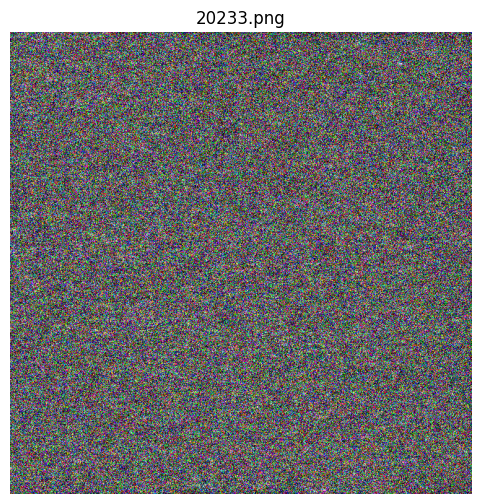

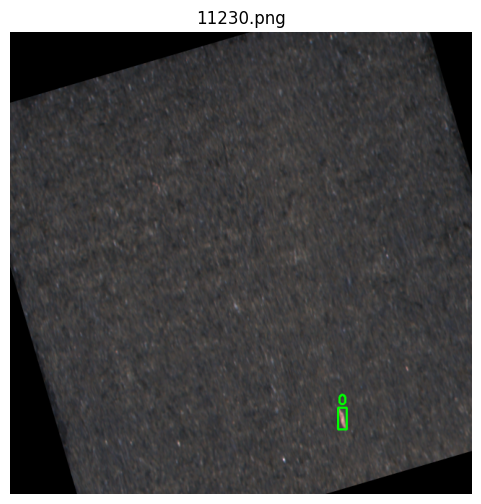

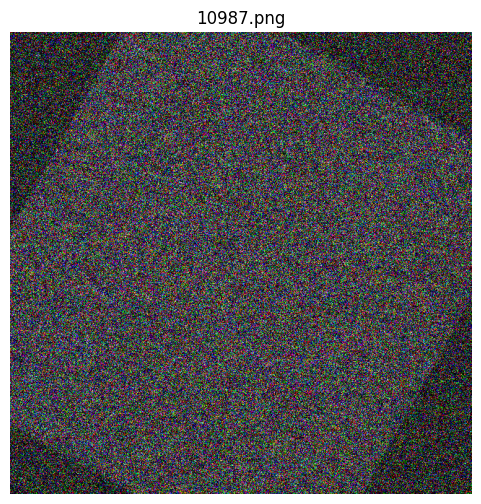

In [8]:
import os
import random
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter

DATA_ROOT = Path("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed")
DATASETS = ["MVTEC_AD", "KolektorSDD"]

def count_files(dataset_path):
    """Count images and labels per split."""
    stats = {}
    for split in ['train', 'val']:
        img_dir = dataset_path / f"images/{split}"
        lbl_dir = dataset_path / f"labels/{split}"

        imgs = list(img_dir.glob("*.png"))
        lbls = list(lbl_dir.glob("*.txt"))

        stats[split] = {
            "images": len(imgs),
            "labels": len(lbls),
            "missing_labels": len([i for i in imgs if not (lbl_dir / (i.stem + ".txt")).exists()])
        }
    return stats


def parse_label_file(label_path):
    """Read YOLO label and return class ids."""
    if not label_path.exists():
        return []
    with open(label_path) as f:
        lines = f.readlines()
    return [int(line.split()[0]) for line in lines if line.strip()]


def class_distribution(lbl_dir):
    """Get frequency of classes in label directory."""
    class_ids = []
    for txt in lbl_dir.glob("*.txt"):
        class_ids += parse_label_file(txt)
    return dict(Counter(class_ids))


def visualize_random_sample(dataset_path, split="val", num_samples=3):
    """Visualize random images with YOLO boxes."""
    img_dir = dataset_path / f"images/{split}"
    lbl_dir = dataset_path / f"labels/{split}"
    imgs = list(img_dir.glob("*.png"))
    if not imgs:
        print(f"No images found in {img_dir}")
        return

    samples = random.sample(imgs, min(num_samples, len(imgs)))

    for img_path in samples:
        image = cv2.imread(str(img_path))
        h, w = image.shape[:2]
        label_path = lbl_dir / f"{img_path.stem}.txt"

        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    c, x, y, bw, bh = map(float, line.split())
                    x1, y1 = int((x - bw/2)*w), int((y - bh/2)*h)
                    x2, y2 = int((x + bw/2)*w), int((y + bh/2)*h)
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
                    cv2.putText(image, str(int(c)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_path.name}")
        plt.axis("off")
        plt.show()

for dataset_name in DATASETS:
    print(f"\n=== DATASET: {dataset_name} ===")
    dataset_path = DATA_ROOT / dataset_name
    stats = count_files(dataset_path)

    for split, s in stats.items():
        print(f"{split.upper()} — Images: {s['images']}, Labels: {s['labels']}, Missing labels: {s['missing_labels']}")

    print("Class Distribution (VAL):", class_distribution(dataset_path / "labels/val"))

    print("\nVisualizing random validation samples...")
    visualize_random_sample(dataset_path, split="val", num_samples=3)


## Validate Label Integrity

In [7]:
import glob

def validate_labels(label_dir):
    bad_labels = []
    for file in glob.glob(f"{label_dir}/*.txt"):
        with open(file, 'r') as f:
            for line in f:
                try:
                    vals = list(map(float, line.split()))
                    if not (0 <= vals[1] <= 1 and 0 <= vals[2] <= 1 and 0 < vals[3] <= 1 and 0 < vals[4] <= 1):
                        bad_labels.append(file)
                except:
                    bad_labels.append(file)
    print("Total label files checked:", len(glob.glob(f"{label_dir}/*.txt")))
    print("Corrupt labels:", len(bad_labels))
    return bad_labels

validate_labels("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/labels/train")
validate_labels("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/KolektorSDD/labels/train")


Total label files checked: 3909
Corrupt labels: 0
Total label files checked: 800
Corrupt labels: 0


[]

## Check Class Distribution

In [6]:
from collections import Counter
import pandas as pd

def class_distribution(label_dir):
    counter = Counter()
    for file in glob.glob(f"{label_dir}/*.txt"):
        with open(file, 'r') as f:
            for line in f:
                cls = int(line.split()[0])
                counter[cls] += 1
    df = pd.DataFrame(counter.items(), columns=["Class", "Count"])
    print(df)

class_distribution("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/labels/train")
class_distribution("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/KolektorSDD/labels/train")


   Class  Count
0      0   2909
1      1   1000
   Class  Count
0      0    427


In [5]:
import glob

def check_class_distribution(label_dir):
    class_counts = {}
    for file in glob.glob(f"{label_dir}/*.txt"):
        with open(file, "r") as f:
            for line in f:
                if line.strip():
                    cls = int(line.split()[0])
                    class_counts[cls] = class_counts.get(cls, 0) + 1
    print(f"Classes found in {label_dir}: {class_counts if class_counts else 'No classes found!'}")

print("=== MVTec AD ===")
check_class_distribution("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTecAD/labels/val")

print("\n=== KolektorSDD ===")
check_class_distribution("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/KolektorSDD/labels/val")


=== MVTec AD ===
Classes found in /Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTecAD/labels/val: No classes found!

=== KolektorSDD ===
Classes found in /Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/KolektorSDD/labels/val: {0: 118}


## Files empty

In [4]:
import os

label_dir = "/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/labels/val"

empty_count = 0
non_empty_count = 0
empty_files = []

for f in os.listdir(label_dir):
    file_path = os.path.join(label_dir, f)
    if os.path.isfile(file_path):
        with open(file_path, "r") as file:
            content = file.read().strip()
            if not content:
                empty_count += 1
                empty_files.append(f)
            else:
                non_empty_count += 1

print(f"Total label files: {len(os.listdir(label_dir))}")
print(f"Empty label files: {empty_count}")
print(f"Non-empty label files: {non_empty_count}")

if empty_files:
    print("\nExample empty files:", empty_files[:10])


Total label files: 978
Empty label files: 0
Non-empty label files: 978


In [3]:
## train contains good images only so all label files should be empty
import os

label_dir = "/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/labels/train"

empty_count = 0
non_empty_count = 0
empty_files = []

for f in os.listdir(label_dir):
    file_path = os.path.join(label_dir, f)
    if os.path.isfile(file_path):
        with open(file_path, "r") as file:
            content = file.read().strip()
            if not content:
                empty_count += 1
                empty_files.append(f)
            else:
                non_empty_count += 1

print(f"Total label files: {len(os.listdir(label_dir))}")
print(f"Empty label files: {empty_count}")
print(f"Non-empty label files: {non_empty_count}")

if empty_files:
    print("\nExample empty files:", empty_files[:10])


Total label files: 3909
Empty label files: 0
Non-empty label files: 3909


## checking non-empty files

In [1]:
import os

label_dir = "/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/labels/val"

valid_lines = 0
invalid_lines = 0

for f in os.listdir(label_dir):
    with open(os.path.join(label_dir, f), "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                valid_lines += 1
            elif len(parts) > 0:
                invalid_lines += 1

print(f"Valid YOLO entries: {valid_lines}")
print(f"Invalid entries: {invalid_lines}")


Valid YOLO entries: 978
Invalid entries: 0


In [2]:
# should be empty files as all are good images with no defects in train
import os

label_dir = "/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/labels/train"

valid_lines = 0
invalid_lines = 0

for f in os.listdir(label_dir):
    with open(os.path.join(label_dir, f), "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                valid_lines += 1
            elif len(parts) > 0:
                invalid_lines += 1

print(f"Valid YOLO entries: {valid_lines}")
print(f"Invalid entries: {invalid_lines}") 


Valid YOLO entries: 3909
Invalid entries: 0


## Kolektor Datasets

In [9]:
## train contains good images only so all label files should be empty
import os

label_dir = "/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/KolektorSDD/labels/train"

empty_count = 0
non_empty_count = 0
empty_files = []

for f in os.listdir(label_dir):
    file_path = os.path.join(label_dir, f)
    if os.path.isfile(file_path):
        with open(file_path, "r") as file:
            content = file.read().strip()
            if not content:
                empty_count += 1
                empty_files.append(f)
            else:
                non_empty_count += 1

print(f"Total label files: {len(os.listdir(label_dir))}")
print(f"Empty label files: {empty_count}")
print(f"Non-empty label files: {non_empty_count}")

if empty_files:
    print("\nExample empty files:", empty_files[:10])


Total label files: 800
Empty label files: 417
Non-empty label files: 383

Example empty files: ['11465.txt', '12150.txt', '20109.txt', '10948.txt', '20492.txt', '20479.txt', '21001.txt', '20337.txt', '10357.txt', '20294.txt']


In [8]:
## val set
## train contains good images only so all label files should be empty
import os

label_dir = "/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/KolektorSDD/labels/val"

empty_count = 0
non_empty_count = 0
empty_files = []

for f in os.listdir(label_dir):
    file_path = os.path.join(label_dir, f)
    if os.path.isfile(file_path):
        with open(file_path, "r") as file:
            content = file.read().strip()
            if not content:
                empty_count += 1
                empty_files.append(f)
            else:
                non_empty_count += 1

print(f"Total label files: {len(os.listdir(label_dir))}")
print(f"Empty label files: {empty_count}")
print(f"Non-empty label files: {non_empty_count}")

if empty_files:
    print("\nExample empty files:", empty_files[:10])


Total label files: 200
Empty label files: 93
Non-empty label files: 107

Example empty files: ['10747.txt', '11854.txt', '20280.txt', '11276.txt', '11510.txt', '10544.txt', '11116.txt', '12033.txt', '20527.txt', '12255_aug3212.txt']


### Preprocessed MVTEC_AD dataset and Analysis

In [13]:
# Cell 1 - imports & config
import os
from pathlib import Path
import glob
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict

BASE_DIR = Path("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD")  
IMG_DIR = BASE_DIR / "images"
LBL_DIR = BASE_DIR / "labels"
OUT_DIR = BASE_DIR / "exploration_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

random.seed(42)


In [14]:
# utility functions
def list_files(path_glob):
    return sorted([Path(p) for p in glob.glob(str(path_glob))])

def read_label_file(label_path):
    # returns list of (class, x_c, y_c, w, h) floats, empty list if file empty
    try:
        with open(label_path, "r") as f:
            lines = [l.strip() for l in f if l.strip()]
        out = []
        for l in lines:
            parts = l.split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            vals = list(map(float, parts[1:]))
            out.append((cls, *vals))
        return out
    except Exception:
        return None  # indicates corrupt/unreadable


In [15]:
# Dataset counts & missing/corrupt checks
report_rows = []

for split in ["train", "val"]:
    imgs = list_files(IMG_DIR / split / "*.*")
    lbls = list_files(LBL_DIR / split / "*.txt")
    img_set = {p.stem for p in imgs}
    lbl_set = {p.stem for p in lbls}

    # matched & missing
    matched = sorted(list(img_set & lbl_set))
    missing_label = sorted(list(img_set - lbl_set))
    missing_image = sorted(list(lbl_set - img_set))

    # check empty label files and corrupt label parsing
    empty_labels = []
    corrupt_labels = []
    nonempty_count = 0
    for lp in lbls:
        content = read_label_file(lp)
        if content is None:
            corrupt_labels.append(lp)
        elif len(content) == 0:
            empty_labels.append(lp)
        else:
            nonempty_count += 1

    report = {
        "split": split,
        "images_total": len(imgs),
        "labels_total": len(lbls),
        "matched_pairs": len(matched),
        "missing_label_files (image without .txt)": len(missing_label),
        "missing_image_files (txt without image)": len(missing_image),
        "empty_label_files": len(empty_labels),
        "corrupt_label_files": len(corrupt_labels),
        "nonempty_label_files": nonempty_count
    }
    report_rows.append(report)

pd.DataFrame(report_rows).set_index("split")


images_total  labels_total  matched_pairs  \
split                                              
train          3909          3909           3909   
val             978           978            978   

       missing_label_files (image without .txt)  \
split                                             
train                                         0   
val                                           0   

       missing_image_files (txt without image)  empty_label_files  \
split                                                               
train                                        0                  0   
val                                          0                  0   

       corrupt_label_files  nonempty_label_files  
split                                             
train                    0                  3909  
val                      0                   978

**class distribution & bbox statistics**

In [17]:
def analyze_labels_for_split(split):
    lbl_paths = list_files(LBL_DIR / split / "*.txt")
    cls_counter = Counter()
    bbox_areas = []
    bbox_wh = []  # list of (w,h) normalized
    corrupt = []
    for lp in lbl_paths:
        parsed = read_label_file(lp)
        if parsed is None:
            corrupt.append(lp)
            continue
        for (cls, x_c, y_c, w, h) in parsed:
            cls_counter[cls] += 1
            bbox_areas.append(w * h)
            bbox_wh.append((w, h))
    return cls_counter, bbox_areas, bbox_wh, corrupt

summary = {}
for split in ["train", "val"]:
    cls_cnt, areas, whs, corrupt = analyze_labels_for_split(split)
    summary[split] = {
        "class_counts": dict(cls_cnt),
        "num_bboxes": sum(cls_cnt.values()),
        "mean_bbox_area": float(np.mean(areas)) if areas else 0.0,
        "median_bbox_area": float(np.median(areas)) if areas else 0.0,
        "bbox_wh_sample": whs[:10],
        "corrupt_label_files": [str(x) for x in corrupt][:10]
    }

import json
print(json.dumps(summary, indent=2))


{
  "train": {
    "class_counts": {
      "0": 2909,
      "1": 1000
    },
    "num_bboxes": 3909,
    "mean_bbox_area": 1.0,
    "median_bbox_area": 1.0,
    "bbox_wh_sample": [
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ]
    ],
    "corrupt_label_files": []
  },
  "val": {
    "class_counts": {
      "1": 258,
      "0": 720
    },
    "num_bboxes": 978,
    "mean_bbox_area": 1.0,
    "median_bbox_area": 1.0,
    "bbox_wh_sample": [
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        1.0,
        1.0
      ],
      [
        

**Image size & aspect ratio distribution**

train - sample images: 1000 | mean W x H = 640.0 x 640.0


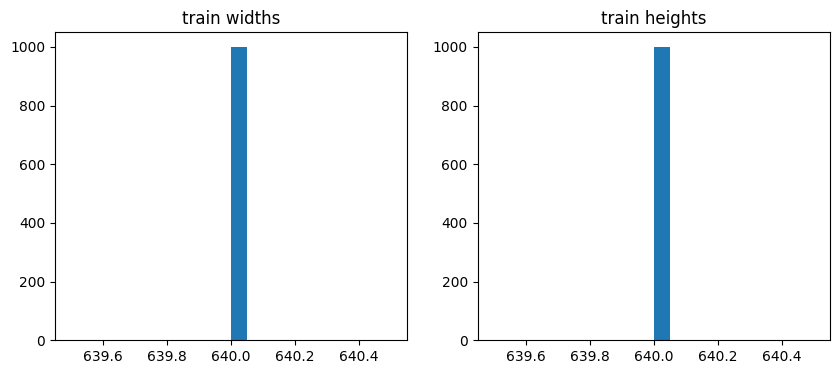

val - sample images: 978 | mean W x H = 640.0 x 640.0


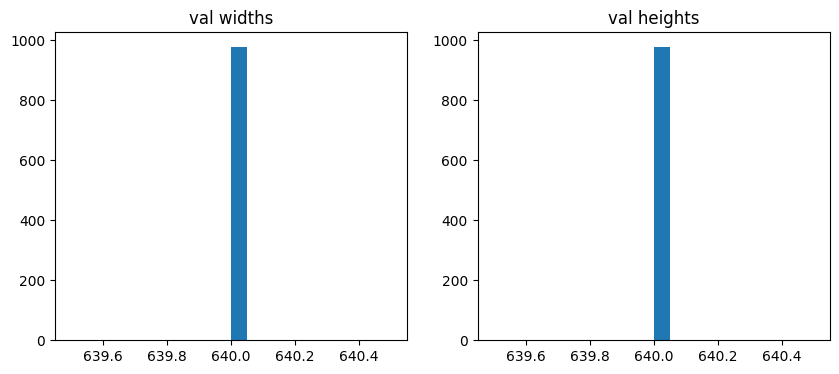

In [18]:
def collect_image_sizes(split, max_samples=None):
    imgs = list_files(IMG_DIR / split / "*.*")
    sizes = []
    for p in (imgs[:max_samples] if max_samples else imgs):
        img = cv2.imread(str(p))
        if img is None:
            continue
        h, w = img.shape[:2]
        sizes.append((w, h))
    return sizes

for split in ["train", "val"]:
    sizes = collect_image_sizes(split, max_samples=1000)
    if not sizes:
        print(f"No sizes for {split}")
        continue
    widths, heights = zip(*sizes)
    print(f"{split} - sample images: {len(sizes)} | mean W x H = {np.mean(widths):.1f} x {np.mean(heights):.1f}")
    # histogram plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(widths, bins=20)
    plt.title(f"{split} widths")
    plt.subplot(1,2,2)
    plt.hist(heights, bins=20)
    plt.title(f"{split} heights")
    plt.show()

**Visualize random samples with boxes (save images)**

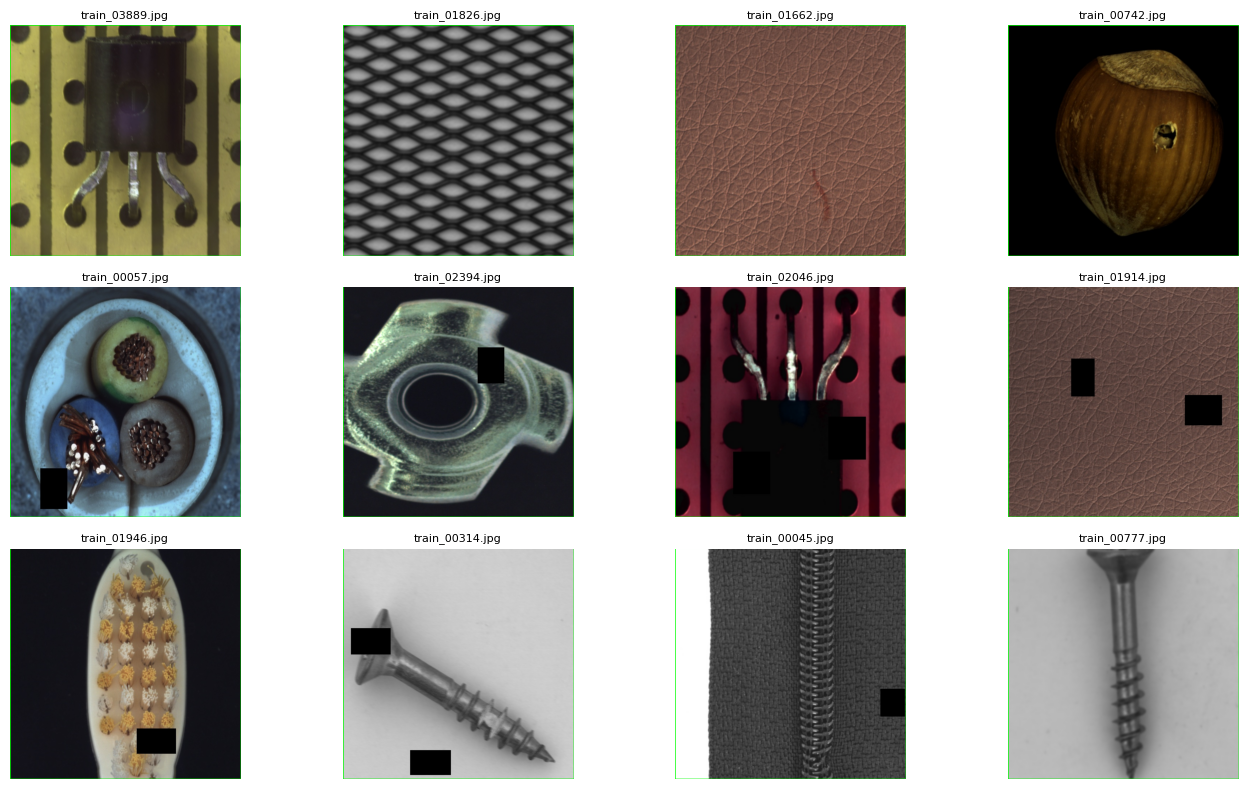

Saved visualizations to: /Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD/visualizations


In [25]:
import os
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# === Paths ===
DATA_ROOT = Path("/Users/ajayyy/Desktop/Deep_Learning/Smart-Quality-Inspection-System/data/processed/MVTEC_AD")
IMG_DIR = DATA_ROOT / "images"
LBL_DIR = DATA_ROOT / "labels"
OUT_DIR = DATA_ROOT / "visualizations"
OUT_DIR.mkdir(exist_ok=True, parents=True)


# === Utility Functions ===
def list_files(pattern):
    """Return list of files matching pattern."""
    from glob import glob
    return [Path(p) for p in glob(str(pattern)) if not os.path.isdir(p)]


def read_label_file(label_path):
    """Reads YOLO label and returns list of [cls, x_c, y_c, w, h]."""
    if not label_path.exists():
        return []
    with open(label_path, "r") as f:
        lines = [l.strip().split() for l in f if l.strip()]
    return [[int(l[0]), float(l[1]), float(l[2]), float(l[3]), float(l[4])] for l in lines]


def overlay_boxes_on_image(img_path, label_path, out_path=None):
    """Overlay YOLO boxes on image and optionally save it."""
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Could not read image: {img_path}")
        return None

    h, w = img.shape[:2]
    parsed = read_label_file(label_path)

    for item in parsed or []:
        cls, x_c, y_c, bw, bh = item
        x1 = int((x_c - bw / 2) * w)
        y1 = int((y_c - bh / 2) * h)
        x2 = int((x_c + bw / 2) * w)
        y2 = int((y_c + bh / 2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, str(cls), (x1, max(y1 - 6, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    if out_path:
        cv2.imwrite(str(out_path), img)

    return img


# === Visualization ===
n_examples = 12
all_train_imgs = list_files(IMG_DIR / "train" / "*.jpg")

if len(all_train_imgs) == 0:
    print("No training images found in:", IMG_DIR / "train")
else:
    sample_imgs = random.sample(all_train_imgs, min(n_examples, len(all_train_imgs)))
    fig = plt.figure(figsize=(14, 8))

    for i, img_p in enumerate(sample_imgs):
        lbl_p = LBL_DIR / "train" / (img_p.stem + ".txt")
        out_p = OUT_DIR / f"viz_{i:02d}.jpg"
        img = overlay_boxes_on_image(img_p, lbl_p, out_path=out_p)

        if img is not None:
            ax = fig.add_subplot(3, 4, i + 1)
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(img_p.name, fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    plt.show()

print("Saved visualizations to:", OUT_DIR)
